In [ ]:
# uncomment if not installed
# !pip install datasets matplotlib promptforest


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [ ]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm

SERVER_URL = "http://localhost:1000/analyze"

DATASETS = [
    {
        "name": "geekyrakshit/prompt-injection-dataset",
        "split": "test",
        "text_cols": ["prompt", "text"],
    },
    {
        "name": "JasperLS/prompt-injections",
        "split": "test",
        "text_cols": ["text", "prompt"],
    },
]

MAX_SAMPLES = 500


def pick_text(example, candidates):
    for c in candidates:
        if c in example and example[c]:
            return example[c]
    raise ValueError("No valid text column found")


def analyse(prompt: str):
    r = requests.post(SERVER_URL, json={"prompt": prompt}, timeout=15)
    r.raise_for_status()
    return r.json()


latencies = []

for cfg in DATASETS:
    print(f"\nRunning {cfg['name']}")
    ds = load_dataset(cfg["name"], split=cfg["split"])
    ds = ds.shuffle(seed=42).select(range(min(len(ds), MAX_SAMPLES)))

    for ex in tqdm(ds):
        text = pick_text(ex, cfg["text_cols"])
        out = analyse(text)
        latencies.append(out["latency_ms"])


latencies = np.array(latencies)

print("\nLatency stats:")
print(f"Mean latency (ms): {latencies.mean():.2f}")
print(f"P95 latency (ms):  {np.percentile(latencies, 95):.2f}")
print(f"Max latency (ms):  {latencies.max():.2f}")



Running geekyrakshit/prompt-injection-dataset


100%|██████████| 500/500 [01:16<00:00,  6.51it/s]



Running JasperLS/prompt-injections


100%|██████████| 116/116 [00:13<00:00,  8.60it/s]


Latency stats:
Mean latency (ms): 142.23
P95 latency (ms):  203.28
Max latency (ms):  463.58


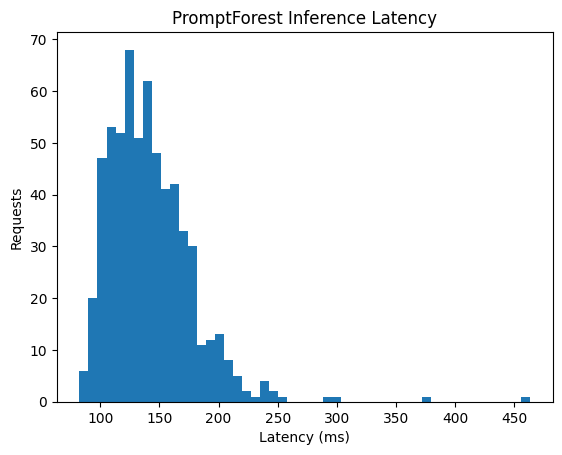

In [11]:
plt.figure()
plt.hist(latencies, bins=50)
plt.xlabel("Latency (ms)")
plt.ylabel("Requests")
plt.title("PromptForest Inference Latency")
plt.show()
